In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import re
!wget http://nlp.stanford.edu/data/glove.6B.zip
!pip install -q wordcloud
import wordcloud
!unzip glove*.zip
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.display import Path
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
import torch.nn as nn
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random
import os
!pip install torchmetrics
os.environ['PYTHONHASHSEED'] = str(69)
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score as skf1
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix

Mounted at /content/drive
--2022-12-07 18:34:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-07 18:34:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-07 18:34:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Savin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 21.2 MB/s 


In [2]:
def randreset(s):
	random.seed(s)
	np.random.seed(s)
	torch.manual_seed(s)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
	torch.cuda.manual_seed_all(s)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [6]:
path = '/content/drive/My Drive/AI2/HW2/imdb-reviews.csv'
testpath = '/content/drive/My Drive/AI2/HW2/imdb-reviews.csv'

df = pd.read_csv(path,  sep='\t', lineterminator='\n')
dftest = pd.read_csv(testpath,  sep='\t', lineterminator='\n')

In [7]:
df['review'] = df['review'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes so don't becomes dont
df['review'] = [r.lower() for r in df['review'] ]   #making everything lowercase
df['review'] = df['review'].apply(lambda r: re.sub(r'<br /><br />', ' ', r))  #removing this wierd sequence found in some reviews
df['review'] = df['review'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters

rem = stopwords.words('english')
df['review'] = df['review'].apply(lambda r: ' '.join([word for word in r.split() if word not in rem]))

dftest['review'] = dftest['review'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes so don't becomes dont
dftest['review'] = [r.lower() for r in dftest['review'] ]   #making everything lowercase
dftest['review'] = dftest['review'].apply(lambda r: re.sub(r'<br /><br />', ' ', r))  #removing this wierd sequence found in some reviews
dftest['review'] = dftest['review'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters

dftest['review'] = dftest['review'].apply(lambda r: ' '.join([word for word in r.split() if word not in rem]))


In [8]:
def vectorize(df, w2v):
	X = list()
	Y = list()
	Scores = list(df['rating'].apply(lambda r: 1 if r > 5 else 0))
	for (i, review) in enumerate(df["review"].values):
		wvectors = list()
		for word in review.split(" "):
			if word in w2v.keys():
				wvectors.append(list(w2v[word]))
		if len(wvectors) > 0:
			X.append(np.mean(wvectors, axis=0))
			Y.append(Scores[i])
	return (X,Y)

In [9]:
w2v = {}

with open('glove.6B.300d.txt', encoding="utf8") as fp:
	for lines in fp:
		varray = lines.split(" ")
		w2v[varray[0]] = np.asarray(varray[1:], dtype='float32')

(X, Y) = vectorize(df, w2v)
(Xtest, Ytest) = vectorize(dftest, w2v)

In [10]:
randreset(666)
Xtrain, Xval , Ytrain, Yval = train_test_split(X, Y, test_size=0.1, random_state=69)

Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)
Yt = torch.tensor(Ytrain, device=device)
print(Xt.shape, Yt.shape)

Xv = torch.tensor(Xval, dtype=torch.float, device=device)
Yv = torch.tensor(Yval, device=device)
print(Xv.shape, Yv.shape)

XT = torch.tensor(Xtest, dtype=torch.float, device=device)
YT = torch.tensor(Ytest, device=device)
print(Xv.shape, Yv.shape)

TrainDataset = torch.utils.data.TensorDataset(Xt, Yt)
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size=6001,shuffle=True)

<ipython-input-10-2dff953d8181>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  Xt = torch.tensor(Xtrain, dtype=torch.float, device=device)


torch.Size([40507, 300]) torch.Size([40507])
torch.Size([4501, 300]) torch.Size([4501])
torch.Size([4501, 300]) torch.Size([4501])


In [11]:
class NeuralNetwork(nn.Module):
  def __init__(self, Din, H1, H2, Dout, drop, activation) -> None:
      super(NeuralNetwork, self).__init__()
      self.linear_relu_stack = nn.Sequential(
          nn.Linear(Din, H1, device=device),
		      nn.Dropout(p=drop),
          activation(),
          nn.Linear(H1, H2, device=device),  #since we can do this without NNs I decided to only use one hidden layer
		      nn.Dropout(p=drop),
          activation(),
          nn.Linear(H2,Dout, device=device)
        )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits


def train(model, epochs, dataloader, optimiser, learningrate, Xval, Yval, prinntTF):
	lastf1 = None
	lastmodel = None
	lossfunction = nn.CrossEntropyLoss()
	optim = getattr(torch.optim, optimiser)(model.parameters(), lr=learningrate) #make lr a scheduler
	for ep in range(epochs):
		model.train()
		for batch, (X,Y) in enumerate(dataloader):
			X = X.to(device)
			Y = Y.to(device)
			Ypred = model(X)
			l = lossfunction(Ypred, Y)
			l.backward()
			optim.step()
			optim.zero_grad()
		with torch.no_grad():
			model.eval()
			_, Vpred = torch.max(model(Xval), 1)
			f1 = f1_score(Yval.cpu(), Vpred.cpu(), average="weighted", num_classes=2, task="multiclass")
			if prinntTF:
				print(f"for epoch = {ep} we got loss = {l.item()} and f1 score with val set = {f1}")
			if lastf1 is None:
				lastf1 = f1 
				lastmodel = model
			else:
				if lastf1 > f1:
					return lastmodel
				else:
					lastf1 = f1
			
	return model



def test(model, Xtest, Ytest):
	with torch.no_grad():
		model.eval()
		_, Ypred = torch.max(model(Xtest), 1)
		Ypred = Ypred.cpu()
		Ytest = Ytest.cpu()
		print(classification_report(Ytest, Ypred))


In [12]:
randreset(666)
model = NeuralNetwork(Xt.shape[1], 128, 128, 2, 0.2, nn.CELU).to(device)
model = train(model, 100, TrainDataloader, "Adam", 0.02, Xv, Yv, False)
test(model, XT, YT)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     22500
           1       0.82      0.85      0.84     22508

    accuracy                           0.83     45008
   macro avg       0.83      0.83      0.83     45008
weighted avg       0.83      0.83      0.83     45008



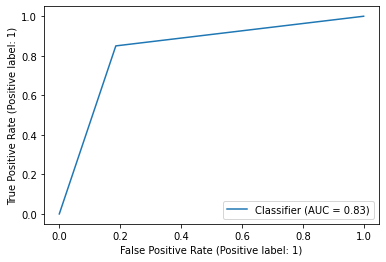

In [13]:
def plotROC(model, Xtest, Ytest):
	with torch.no_grad():
		model.eval()
		_, Ypred = torch.max(model(Xtest), 1)
		Ypred = Ypred.cpu()
		Ytest = Ytest.cpu()
		RocCurveDisplay.from_predictions(Ytest, Ypred)
		plt.show()
plotROC(model, XT, YT)